In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv('tugas_genap.csv')

# Tampilkan 5 baris pertama untuk cek data
print(df.head())


                              game_name  meta_score  user_score  \
0  The Legend of Zelda: Ocarina of Time        99.0        91.0   
1                    Super Mario Galaxy        97.0        91.0   
2                  Super Mario Galaxy 2        97.0        91.0   
3                         Metroid Prime        97.0        89.0   
4                   Super Mario Odyssey        97.0        89.0   

          platform                                        description  \
0  ['nintendo-64']  As a young boy, Link is tricked by Ganondorf, ...   
1          ['wii']  [Metacritic's 2007 Wii Game of the Year] The u...   
2          ['wii']  Super Mario Galaxy 2, the sequel to the galaxy...   
3     ['gamecube']  Samus returns in a new mission to unravel the ...   
4       ['switch']  New Evolution of Mario Sandbox-Style Gameplay....   

                                                 url            developer  \
0  https://www.metacritic.com/game/nintendo-64/th...             Nintendo   
1  h

In [2]:
# Informasi dataset
print(df.info())

# Statistik deskriptif untuk skor dan meta_score
print(df[['meta_score', 'user_score']].describe())

# Cek jumlah platform unik
print("Platform unik:", df['platform'].explode().nunique())

# Cek genre unik (karena genre berupa list string)
import ast

# Fungsi konversi string list menjadi list python
def parse_list(x):
    try:
        return ast.literal_eval(x)
    except:
        return []

# Terapkan parsing ke kolom genre dan platform
df['genre'] = df['genre'].apply(parse_list)
df['platform'] = df['platform'].apply(parse_list)

# Hitung genre unik
all_genres = sum(df['genre'], [])
unique_genres = set(all_genres)
print(f"Jumlah genre unik: {len(unique_genres)}")
print(f"Genre unik: {unique_genres}")

# Cek rating unik
print("Rating unik:", df['rating'].unique())

# Cek tipe game unik
print("Tipe game unik:", df['type'].unique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   game_name    2000 non-null   object 
 1   meta_score   2000 non-null   float64
 2   user_score   2000 non-null   float64
 3   platform     2000 non-null   object 
 4   description  1980 non-null   object 
 5   url          2000 non-null   object 
 6   developer    1998 non-null   object 
 7   genre        1999 non-null   object 
 8   type         1571 non-null   object 
 9   rating       1696 non-null   object 
dtypes: float64(2), object(8)
memory usage: 156.4+ KB
None
        meta_score   user_score
count  2000.000000  2000.000000
mean     80.854000    76.765000
std       5.179392    10.225804
min      74.000000    12.000000
25%      77.000000    73.000000
50%      80.000000    78.000000
75%      83.000000    84.000000
max      99.000000    92.000000
Platform unik: 22
Jumlah genre unik: 151
G

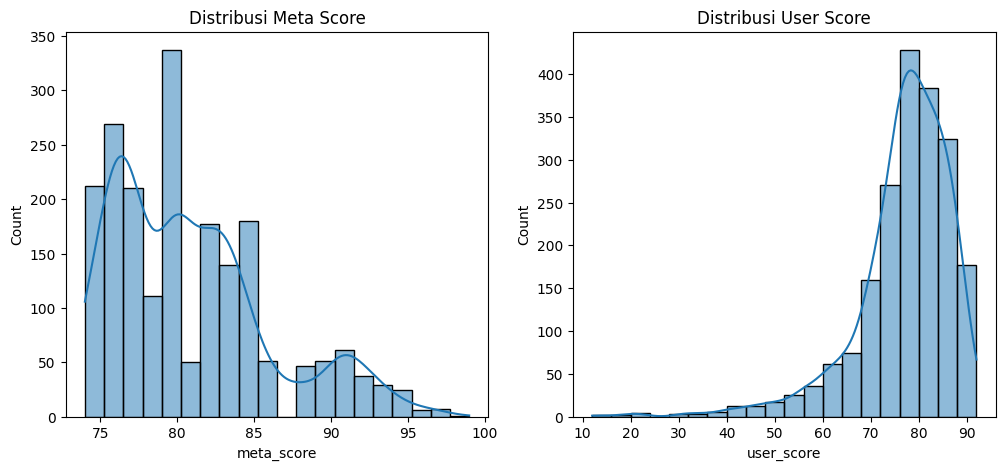

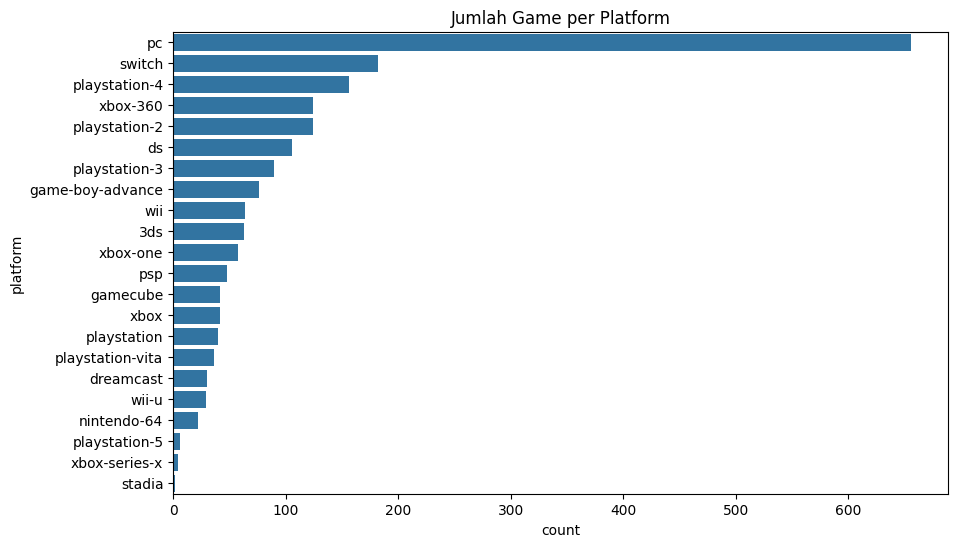

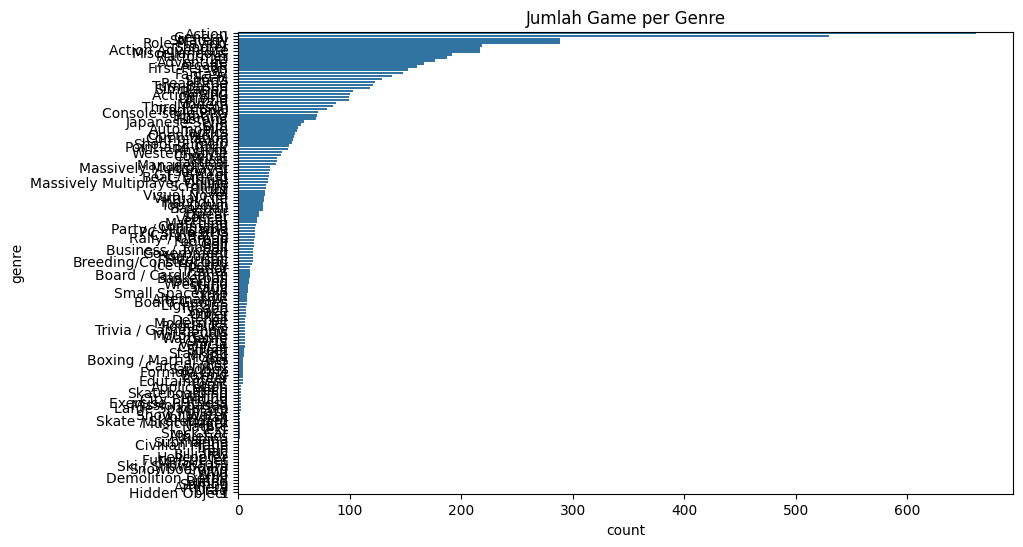

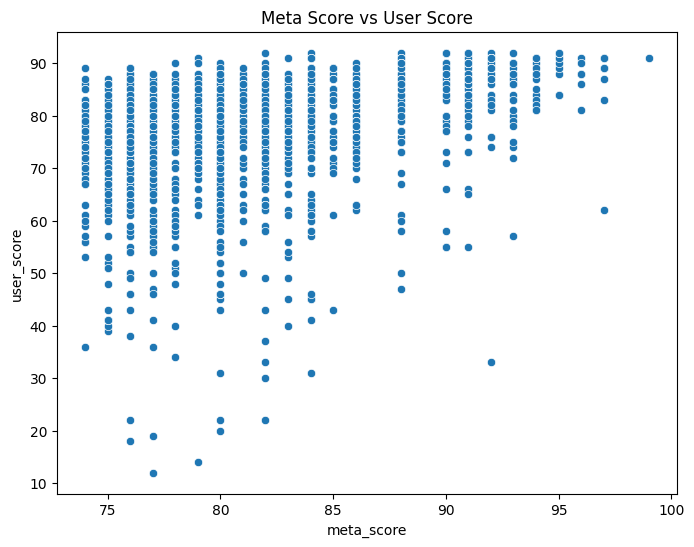

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram meta_score dan user_score
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df['meta_score'], bins=20, kde=True)
plt.title('Distribusi Meta Score')

plt.subplot(1,2,2)
sns.histplot(df['user_score'], bins=20, kde=True)
plt.title('Distribusi User Score')
plt.show()

# Jumlah game per platform
platforms = df['platform'].explode()
plt.figure(figsize=(10,6))
sns.countplot(y=platforms, order=platforms.value_counts().index)
plt.title('Jumlah Game per Platform')
plt.show()

# Jumlah game per genre (mengexplode genre)
genres = df['genre'].explode().astype(str)

# Hitung frekuensi genre
genre_counts = genres.value_counts().reset_index()
genre_counts.columns = ['genre', 'count']

plt.figure(figsize=(10,6))
sns.barplot(data=genre_counts, y='genre', x='count', order=genre_counts['genre'])
plt.title('Jumlah Game per Genre')
plt.show()

# Scatterplot meta_score vs user_score
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='meta_score', y='user_score')
plt.title('Meta Score vs User Score')
plt.show()


In [5]:
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, MinMaxScaler

# Genre one-hot
mlb_genre = MultiLabelBinarizer()
genre_encoded = mlb_genre.fit_transform(df['genre'])

# Platform one-hot
mlb_platform = MultiLabelBinarizer()
platform_encoded = mlb_platform.fit_transform(df['platform'])

# Tipe game encoding
le_type = LabelEncoder()
type_encoded = le_type.fit_transform(df['type'])

# Rating encoding
le_rating = LabelEncoder()
rating_encoded = le_rating.fit_transform(df['rating'])

# Normalisasi meta_score dan user_score
scaler = MinMaxScaler()
score_scaled = scaler.fit_transform(df[['meta_score', 'user_score']])

import numpy as np

# Gabungkan semua fitur menjadi matriks fitur
X = np.hstack([
    genre_encoded,
    platform_encoded,
    type_encoded.reshape(-1,1),
    rating_encoded.reshape(-1,1),
    score_scaled
])

print(f"Shape fitur gabungan: {X.shape}")


Shape fitur gabungan: (2000, 177)


In [6]:
from scipy.spatial.distance import euclidean

def recommend_games(game_name, top_n=5):
    # Cari indeks game
    try:
        idx = df.index[df['game_name'] == game_name][0]
    except IndexError:
        return f"Game '{game_name}' tidak ditemukan di dataset."

    target_vector = X[idx]

    distances = []
    for i in range(len(df)):
        if i == idx:
            continue
        dist = euclidean(target_vector, X[i])
        distances.append((i, dist))

    # Urutkan berdasarkan jarak terkecil (mirip)
    distances = sorted(distances, key=lambda x: x[1])

    # Ambil top_n terdekat
    recommended_indices = [i for i, d in distances[:top_n]]

    # Tampilkan nama game rekomendasi
    recommendations = df.iloc[recommended_indices][['game_name', 'meta_score', 'user_score', 'platform', 'genre']]
    return recommendations


In [7]:
print(recommend_games('The Legend of Zelda: Ocarina of Time', top_n=5))


                                             game_name  meta_score  \
19                  The Legend of Zelda: Majora's Mask        95.0   
10                 The Legend of Zelda: The Wind Waker        96.0   
16             The Legend of Zelda Collector's Edition        95.0   
129  The Legend of Zelda: Ocarina of Time / Master ...        91.0   
18             The Legend of Zelda: A Link to the Past        95.0   

     user_score            platform                        genre  
19         91.0       [nintendo-64]  [Action Adventure, Fantasy]  
10         90.0          [gamecube]  [Action Adventure, Fantasy]  
16         89.0          [gamecube]  [Action Adventure, Fantasy]  
129        89.0          [gamecube]  [Action Adventure, Fantasy]  
18         90.0  [game-boy-advance]  [Action Adventure, Fantasy]  


In [8]:
def evaluate_recommender():
    distances_all = []
    for i in range(len(df)):
        target = X[i]
        for j in range(len(df)):
            if i == j:
                continue
            dist = euclidean(target, X[j])
            distances_all.append(dist)
    import numpy as np
    print("Mean Euclidean Distance antar game:", np.mean(distances_all))
    print("Std Dev Euclidean Distance antar game:", np.std(distances_all))

evaluate_recommender()


Mean Euclidean Distance antar game: 4.275494634754117
Std Dev Euclidean Distance antar game: 1.3647367015268608
